In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
import numpy as np

def stochastic_rk4(f, g, y0, t0, t_end, h, rng=None, **kwargs):
    """
    Simplified stochastic RK4 integrator for SDEs:
    dy = f(t, y) dt + g(t, y) dW_t

    Parameters:
    - f: drift function, f(t, y, **kwargs)
    - g: diffusion function, g(t, y, **kwargs)
    - y0: initial value
    - t0: initial time
    - t_end: end time
    - h: step size
    - rng: numpy random generator (optional)
    - kwargs: additional arguments to pass to f and g

    Returns:
    - ts: array of time steps
    - ys: array of solution values
    """
    if rng is None:
        rng = np.random.default_rng()

    ts = [t0]
    ys = [y0]
    t = t0
    y = y0

    while t < t_end:
        if t + h > t_end:
            h = t_end - t

        dW = rng.normal(0.0, np.sqrt(h))  # Brownian increment

        # Drift RK-style (Euler fallback for simplicity)
        k1 = f(t, y, **kwargs)
        k2 = f(t + h / 2, y + h * k1 / 2, **kwargs)
        k3 = f(t + h / 2, y + h * k2 / 2, **kwargs)
        k4 = f(t + h, y + h * k3, **kwargs)
        drift = (k1 + 2*k2 + 2*k3 + k4) / 6

        # Diffusion (Euler-style)
        diffusion = g(t, y, **kwargs)

        y = y + h * drift + diffusion * dW
        t += h

        ts.append(t)
        ys.append(y)

    return np.array(ts), np.array(ys)


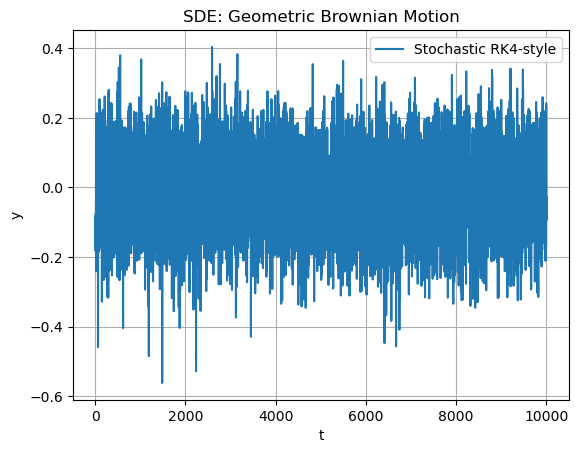

In [40]:
def SLM(t, x, A=None, r=1, **kwargs):
    if A is None:
        A = np.eye(len(x))
    return r * (x - x*np.dot(A,x))

def noise(t, x, sigma=1, **kwargs):
    return sigma*x

# Parameters
S = 10
y0 = np.random.rand(S)
t0 = 0.0
t_end = 1e4
h = 1
sigma = 1 / S

ts, ys = stochastic_rk4(SLM, noise, y0, t0, t_end, h, sigma=sigma)

# Plot result
plt.plot(ts[10:], np.log(ys[10:,0]), label="Stochastic RK4-style")
plt.xlabel("t")
plt.ylabel("y")
plt.title("SDE: Geometric Brownian Motion")
plt.grid(True)
plt.legend()
plt.show()

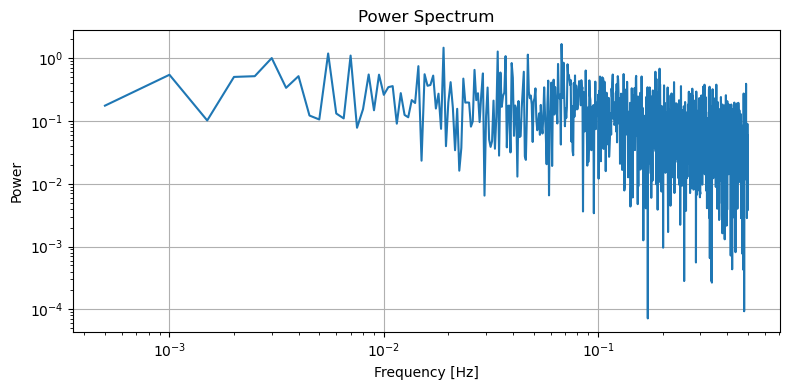

In [41]:
dt = ts[1] - ts[0]  # assume uniform spacing
signal = ys[5000:7000,0]
n = len(signal)
S = np.zeros(n)
for i in range(len(ys[0])):
    signal = np.log(ys[5000:7000,i])
    freqs = np.fft.fftfreq(n, dt)
    fft_vals = np.fft.fft(signal - np.mean(signal))  # remove DC component
    psd = (np.abs(fft_vals) ** 2) / (n * dt)  # normalize
    S += psd

# Keep only the positive frequencies
idx = np.where(freqs > 0)
freqs = freqs[idx]
S = S[idx]


plt.figure(figsize=(8, 4))
plt.plot(freqs, S)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.title("Power Spectrum")
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig("./Images/PSD_pyhton.png")
plt.show()
